# Setup e carregamento do Dataset

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_wine

In [ ]:
dataset = load_wine()
X = pd.DataFrame(dataset.data, columns=dataset.feature_names) # type: ignore
y = pd.Series(dataset.target) # type: ignore

# Análise Exploratória

**Verificando um possível desbalanceamento de classes**

Ao iniciar a análise de um dataset para um problema de classificação, sempre começo verificando
o balanceamento das classes. Com o Dataset de vinhos, há um leve desbalanceamento de classes, com a
classe majoritária possuindo 71 amostras, a 2a classe 59, e a minoritária 48.

No entanto, é um desbalanceamento pequeno, e não deve afetar a performance do classificador. Então,
por enquanto, decidi manter as classes como estão, ao invés de balancear. Caso fosse balancear,
utilizaria uma estratégia de downsampling, reduzindo a quantidade de amostras das classes majoritárias.

**Verificando a presença de valores nulos**

Não há a presença de valores nulos ou NaN no dataset em questão.

In [4]:
y.value_counts()

1    71
0    59
2    48
Name: count, dtype: int64

In [25]:
X.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

**Importância das Features**

Em seguida, tentei observar a importância das features do dataset. Para esse fim, realizei duas análises:
primeiramente, como as features numéricas do dataset se correlacionam, e, posteriormente, uma análise de relação com
as labels usando uma métrica chamada Mutual Information (MI).

A informação mútua, como a correlação, mede a relação entre duas variáveis. No entanto, diferente da correlação,
a MI pode detectar relações não lineares. Podemos definir a MI como uma métrica que avalia a "quantidade de informação"
que uma variável aleatória fornece sobre outra, sendo fortemente ligada ao conceito de entropia em teoria da informação.

Achados:
- As features "Flavanoids", "Total Phenols" e "Od280/315 of diluted wine" possuem alta correlação (>0.7)
- As features "Flavanoids", "Color Intensity", e "Proline" são as que fornecem mais informações sobre a label de um sample
- No geral, as features, individualmente, não oferecem muita informação sobre as labels, indicando a necessidade da utilização de múltiplas features para inferência

Decidi selecionar, para uma análise inicial, as seguintes features como as mais importantes:
- Flavanoids
- Color Intensity
- Proline
- Alcohol
- Hue

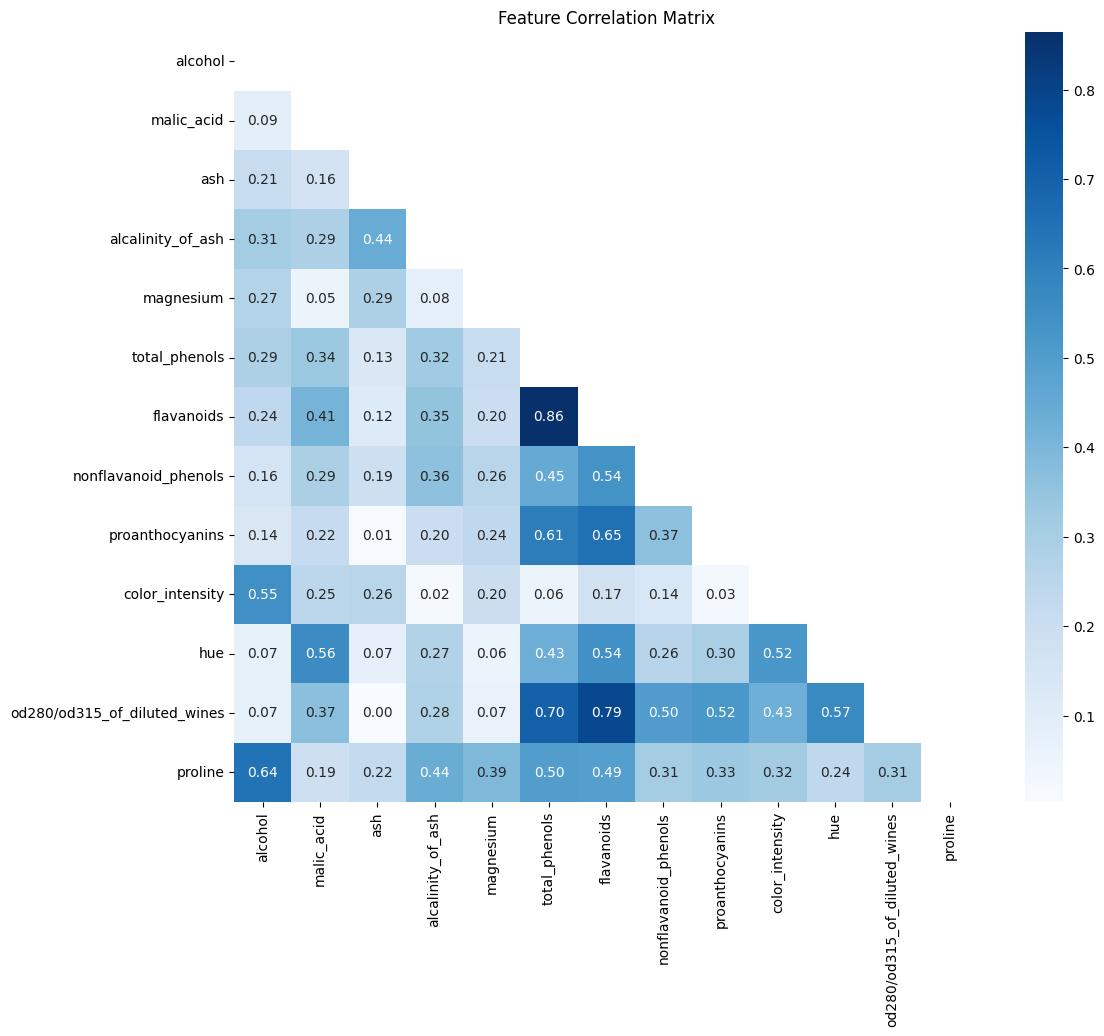

In [65]:
import numpy as np
import seaborn as sns

corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

for name, column in corr_matrix.items():
    corr_matrix[name] = column.map(lambda x: abs(x))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="Blues", fmt=".2f")

plt.title("Feature Correlation Matrix")
plt.show()

In [18]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y, discrete_features=False)
mi = pd.DataFrame({"Feature": X.columns, "Mutual Info": mi})
mi = mi.sort_values("Mutual Info", axis=0, ascending=False)
mi.reset_index(drop=True)

,Feature,Mutual Info
0,flavanoids,0.671470
1,color_intensity,0.553605
2,proline,0.547509
3,od280/od315_of_diluted_wines,0.499488
4,alcohol,0.464142
5,hue,0.452150
6,total_phenols,0.399733
7,proanthocyanins,0.287372
8,malic_acid,0.282708
9,alcalinity_of_ash,0.240153


**Buscando Outliers**

Uma busca simples por outliers usando Z-score com threshold de Z=3 revela três outliers, relacionados
com as features Flavanoids, Hue e Color Intensity. Pelo tamanho reduzido e pela escolha de modelo,
decidi remover (ou alterar) os valores apenas se os julgasse impossíveis (indicando um possível erro de medição).

Para isso, fiz uma breve pesquisa sobre essas medições para vinho. Baseado no que eu pesquisei, todos os
valores aparentam serem possíveis, embora seja difícil de constatar sem saber a unidade de medida para esses
valores.

In [56]:
selected_features = ["flavanoids", "color_intensity", "alcohol", "hue", "proline"]
X_selected = X[selected_features]
X_selected.describe()

,flavanoids,color_intensity,alcohol,hue,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000
mean,2.029270,5.058090,13.000618,0.957449,746.893258
std,0.998859,2.318286,0.811827,0.228572,314.907474
min,0.340000,1.280000,11.030000,0.480000,278.000000
25%,1.205000,3.220000,12.362500,0.782500,500.500000
50%,2.135000,4.690000,13.050000,0.965000,673.500000
75%,2.875000,6.200000,13.677500,1.120000,985.000000
max,5.080000,13.000000,14.830000,1.710000,1680.000000


In [57]:
z_scores = ((X_selected - X_selected.mean()) / X_selected.std())
outlier_mask = (np.abs(z_scores) > 3)

rows_with_outliers = X_selected[outlier_mask.any(axis=1)]
rows_with_outliers

,flavanoids,color_intensity,alcohol,hue,proline
115,2.17,1.9,11.03,1.71,407.0
121,5.08,6.0,11.56,0.93,465.0
158,1.31,13.0,14.34,0.57,660.0


**Distribuições**

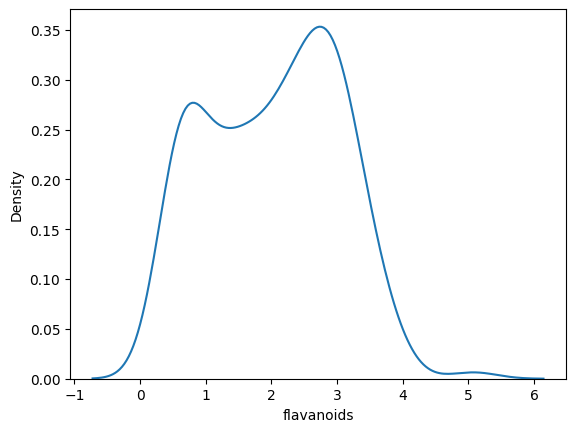

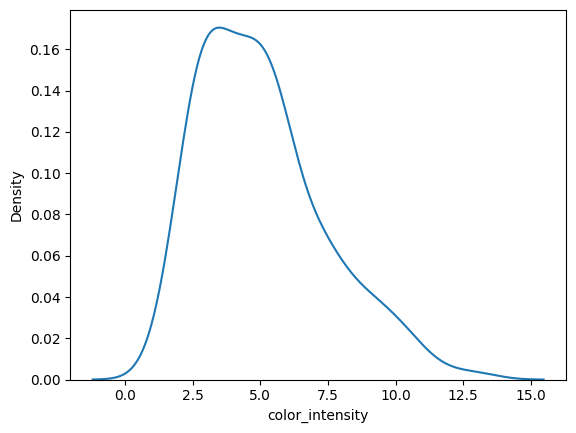

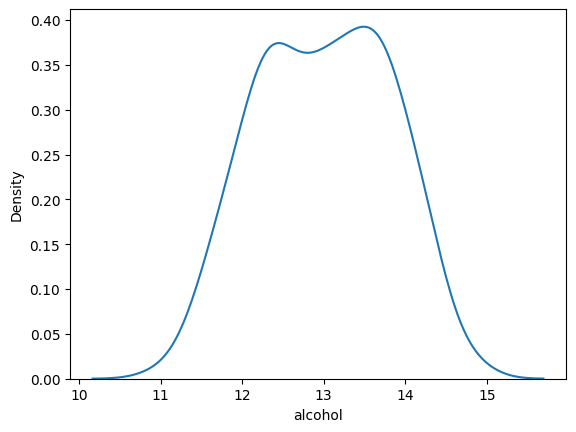

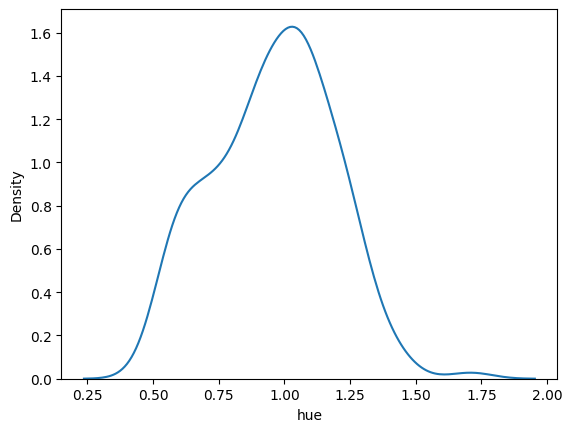

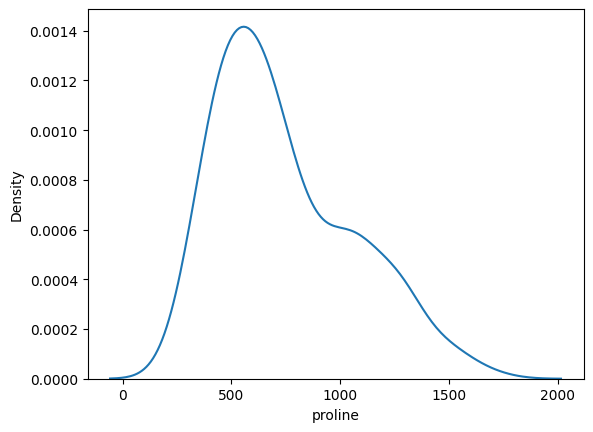

In [66]:
for column in selected_features:
    plt.figure()
    sns.kdeplot(X, x=column, fill=False)
    plt.show()